In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
import joblib
from xgboost import XGBClassifier
import pprint
import matplotlib.pyplot as plt
import numpy as np

# plot_tree()


In [2]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1'
    )

    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.title("Learning Curves (XGBoost)")
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [3]:
telco = pd.read_csv(
    "../dataset/Telco-Customer-Churn.csv",
    index_col="customerID",
)
telco.drop_duplicates(inplace=True)
telco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7021 non-null   object 
 1   SeniorCitizen     7021 non-null   int64  
 2   Partner           7021 non-null   object 
 3   Dependents        7021 non-null   object 
 4   tenure            7021 non-null   int64  
 5   PhoneService      7021 non-null   object 
 6   MultipleLines     7021 non-null   object 
 7   InternetService   7021 non-null   object 
 8   OnlineSecurity    7021 non-null   object 
 9   OnlineBackup      7021 non-null   object 
 10  DeviceProtection  7021 non-null   object 
 11  TechSupport       7021 non-null   object 
 12  StreamingTV       7021 non-null   object 
 13  StreamingMovies   7021 non-null   object 
 14  Contract          7021 non-null   object 
 15  PaperlessBilling  7021 non-null   object 
 16  PaymentMethod     7021 non-null 

In [4]:
telco["TotalCharges"] = pd.to_numeric(telco["TotalCharges"], errors="coerce")
telco["TotalCharges"]

customerID
7590-VHVEG      29.85
5575-GNVDE    1889.50
3668-QPYBK     108.15
7795-CFOCW    1840.75
9237-HQITU     151.65
               ...   
6840-RESVB    1990.50
2234-XADUH    7362.90
4801-JZAZL     346.45
8361-LTMKD     306.60
3186-AJIEK    6844.50
Name: TotalCharges, Length: 7021, dtype: float64

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    telco.drop(columns="Churn"), telco["Churn"], test_size=0.2, random_state=42
)

In [6]:
standard_scaler = StandardScaler()

binary_encoder = OrdinalEncoder(
    categories=[
        ["Yes", "No"], ["Yes", "No"], ["Yes", "No"],
        ["Yes", "No", "No phone service"],
        ["Yes", "No", "No internet service"],
        ["Yes", "No", "No internet service"],
        ["Yes", "No", "No internet service"],
        ["Yes", "No", "No internet service"],
        ["Yes", "No", "No internet service"],
        ["Yes", "No", "No internet service"],
        ["Yes", "No"]]
)

ordinal_encoder = OrdinalEncoder(categories=[["Month-to-month", "One year", "Two year"]], )

one_hot_encoder = OneHotEncoder(categories=[
    ["Male", "Female"],
    ["Fiber optic", "DSL", "No"],
    ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
],
    sparse_output=False
)

label_encoder = LabelEncoder()

transformer = ColumnTransformer(
    transformers=[
        (
            "binary",
            binary_encoder,
            ['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
             'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
             'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
        ),
        (
            "ordinal",
            ordinal_encoder,
            ['Contract']
        ),
        ("onehot", one_hot_encoder, ["gender", "InternetService", "PaymentMethod"]),
        (
            "imputer",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", standard_scaler)
                ]
            ),
            ['tenure', 'MonthlyCharges', 'TotalCharges']
        ),
    ],
    remainder="passthrough",

)
predictor = RandomForestClassifier(
    class_weight={0: 1, 1: 2.5}
)

pipeline = Pipeline(
    steps=[
        ("transformer", transformer),
        ("pca", PCA()),
        ("predictor", predictor),
    ]
)


# encoder_transformer.set_output(transform="pandas")

y_train_transformed = label_encoder.fit_transform(y_train)

param_config_grid = {
    #PCA
    "pca__n_components": [5, 8, 10, 15], # Number of principal components to keep
    "pca__whiten": [True, False], # Whether to whiten the components (decorrelate and scale to unit variance)
    "pca__svd_solver": ["auto", "full", "arpack"], # SVD solver to use (auto is usually fine)
    # --- Forest Structure ---
    "predictor__n_estimators": [100, 200, 500], # More trees = more stability, but slower
    "predictor__criterion": ["gini", "entropy", "log_loss"], # How to measure the quality of a split

    # --- Tree Depth & Growth ---
    "predictor__max_depth": [None, 10, 20, 30], # Limits how deep the trees go
    "predictor__max_leaf_nodes": [None, 50, 100], # Hard limit on total leaves per tree

    # --- Samples & Splitting (Regularization) ---
    "predictor__min_samples_split": [2, 5, 10], # Minimum samples needed to split a node
    "predictor__min_samples_leaf": [1, 2, 4], # Minimum samples required at a leaf node
    "predictor__min_weight_fraction_leaf": [0.0, 0.01, 0.05], # Useful for imbalanced data

    # --- Feature Randomness ---
    "predictor__max_features": ["sqrt", "log2", None], # Number of features to consider at each split
    "predictor__ccp_alpha": [0.0, 0.01, 0.1], # Minimal Cost-Complexity Pruning (very powerful for trees)

    # --- Quality Control ---
    "predictor__min_impurity_decrease": [0.0, 0.01, 0.05], # Only split if it improves the model by this much
    "predictor__bootstrap": [True, False], # Whether to use the whole dataset or samples for each tree
}

model = RandomizedSearchCV(
    pipeline,
    param_config_grid,
    n_iter=25,
    scoring = "f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
    # random_state=None,
)

model.fit(x_train, y_train_transformed)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...1, 1: 2.5}))])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'pca__n_components': [5, 8, ...], 'pca__svd_solver': ['auto', 'full', ...], 'pca__whiten': [True, False], 'predictor__bootstrap': [True, False], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",25
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that c

In [153]:
# 1. Get the fitted transformer from your model
# 'best_estimator_' is the actual pipeline found by RandomizedSearch
fitted_pipeline = model.best_estimator_

# 2. Slice the pipeline to get everything EXCEPT the last step (the predictor)
# This runs the ColumnTransformer and the Scaler
preprocessing_steps = fitted_pipeline[:-1]

# 3. Transform your x_train through those steps
x_train_transformed = preprocessing_steps.transform(x_train)

# 4. View it
x_train_transformed

array([[-0.13054558, -1.40886965, -0.57940679, ..., -0.05006642,
         1.36535406, -0.10660072],
       [ 0.44393307, -0.44654778, -0.9102267 , ...,  1.19387633,
        -1.48384519, -0.96927273],
       [-1.78025063,  0.02327102, -0.37334647, ..., -1.50075878,
        -0.71929147,  0.4803321 ],
       ...,
       [-0.02369623, -0.5885213 ,  0.94833344, ...,  0.90460302,
        -1.55127673, -1.23584464],
       [-1.56268857,  1.19462754, -0.10718596, ...,  1.40982885,
         1.64985917,  0.18742124],
       [-1.58530282,  0.75039266, -0.28645243, ...,  1.0997132 ,
         0.27614799, -0.90884996]])

In [10]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Transform the target variable using the same label encoder
    # y_test_transformed = label_encoder.transform(y_test)
    y_test_transformed = y_test.copy()
    y_train_transformed = y_train.copy()

    prediction = model.predict(x_test)
    prediction_train = model.predict(x_train)


    accuracy = accuracy_score(y_test_transformed, prediction)
    train_accuracy = accuracy_score(prediction_train, y_train_transformed)


    classification_rep = classification_report(y_test_transformed, prediction)
    conf_matrix = confusion_matrix(y_test_transformed, prediction)


    recall = recall_score(y_test_transformed, prediction)
    recall_train = recall_score(y_train_transformed, prediction_train)

    precision = precision_score(y_test_transformed, prediction)
    precision_train = precision_score(y_train_transformed, prediction_train)

    f1 = f1_score(y_test_transformed, prediction)
    f1_train = f1_score(y_train_transformed, prediction_train)
    #

    # print(f"Classification Report:\n{classification_rep}")
    # print(f"Confusion Matrix:\n{conf_matrix}")
    pprint.pprint(model.best_params_)
    print(f"Accuracy: {accuracy}, Train Accuracy: {train_accuracy}")
    print(f"Recall: {recall}, Train Recall: {recall_train}")
    print(f"Precision: {precision}, Train Precision: {precision_train}")
    print(f"F1 Score: {f1}, Train F1 Score: {f1_train}")

y_test_transformed = label_encoder.transform(y_test)

evaluate_model(model, x_train, y_train_transformed, x_test, y_test_transformed)

# plot_learning_curve(model, x_train, y_train_transformed)

# conf_matrix

{'pca__n_components': 8,
 'pca__svd_solver': 'auto',
 'pca__whiten': False,
 'predictor__bootstrap': False,
 'predictor__ccp_alpha': 0.01,
 'predictor__criterion': 'entropy',
 'predictor__max_depth': 10,
 'predictor__max_features': 'sqrt',
 'predictor__max_leaf_nodes': None,
 'predictor__min_impurity_decrease': 0.0,
 'predictor__min_samples_leaf': 1,
 'predictor__min_samples_split': 2,
 'predictor__min_weight_fraction_leaf': 0.05,
 'predictor__n_estimators': 500}
Accuracy: 0.7395017793594306, Train Accuracy: 0.7583689458689459
Recall: 0.7727272727272727, Train Recall: 0.772093023255814
Precision: 0.4874551971326165, Train Precision: 0.5340073529411765
F1 Score: 0.5978021978021978, Train F1 Score: 0.6313501765824504


In [160]:
# classification_rep
joblib.dump(classification_rep, r"../models/random_forest/classification_report.txt")
joblib.dump(model, r"../models/random_forest/model.joblib")

['../models/random_forest/model.joblib']

### XGBoost


In [183]:
predictor = XGBClassifier(
    scale_pos_weight=2.5,
    random_state=42,
    eval_metric='logloss'  # Keep this, it helps track performance
)
pipeline_xgb = Pipeline(
    steps=[
        ("transformer", transformer),
        ("pca", PCA(n_components=8)),
        ("predictor", predictor),
    ]
)

param_config_grid_xgb = {
    "predictor__max_depth": [4, 5, 6, 7, 8, 9], # Force shallow trees
    "predictor__min_child_weight": [5, 6, 7, 8], # Require more samples per leaf
    "predictor__gamma": [1], # High penalty for complex trees
    "predictor__learning_rate": [0.003, 0.006, 0.009],
    "predictor__n_estimators": [300]
}

model_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_config_grid_xgb,
    n_iter=30, # Start with 30 to see the initial results
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

model_xgb.fit(x_train, y_train_transformed)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","Pipeline(step...=None, ...))])"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'predictor__gamma': [1], 'predictor__learning_rate': [0.003, 0.006, ...], 'predictor__max_depth': [4, 5, ...], 'predictor__min_child_weight': [5, 6, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",30
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strateg

In [184]:
evaluate_model(model_xgb, x_train, y_train_transformed, x_test, y_test_transformed)

{'predictor__gamma': 1,
 'predictor__learning_rate': 0.006,
 'predictor__max_depth': 5,
 'predictor__min_child_weight': 7,
 'predictor__n_estimators': 300}
Accuracy: 0.7572953736654804, Train Accuracy: 0.7975427350427351
Recall: 0.7613636363636364, Train Recall: 0.8172757475083057
Precision: 0.5104761904761905, Train Precision: 0.5879541108986616
F1 Score: 0.6111744583808438, Train F1 Score: 0.6839032527105922


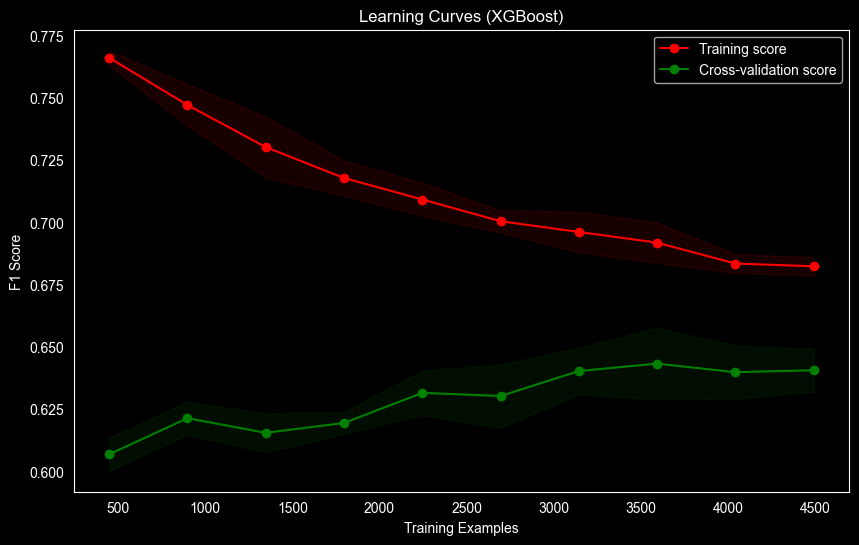

In [185]:
plot_learning_curve(model_xgb.best_estimator_, x_train, y_train_transformed)

In [192]:

joblib.dump(model_xgb, r"../models/xgboost/model.joblib")

['../models/xgboost/model.joblib']

### AdaBoost

In [198]:
predictor = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.01,
    random_state=42
)
pipeline_ada = Pipeline(
    steps=[
        ("transformer", transformer),
        ("pca", PCA()),
        ("predictor", predictor),
    ]
)
param_config_grid_ada = {
    # PCA (Let's keep it for a fair comparison with your others)
    "pca__n_components": [5, 8, 10, 15],
    "pca__whiten": [True, False],

    # --- AdaBoost Specifics ---
    "predictor__n_estimators": [50, 100, 200, 500],
    "predictor__learning_rate": [0.0005, 0.0001],
}

model_ada = RandomizedSearchCV(
    pipeline_ada,
    param_distributions=param_config_grid_ada,
    n_iter=20,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

model_ada.fit(x_train, y_train_transformed)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'pca__n_components': [5, 8, ...], 'pca__whiten': [True, False], 'predictor__learning_rate': [0.0005, 0.0001], 'predictor__n_estimators': [50, 100, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that 

In [199]:
evaluate_model(model_ada, x_train, y_train_transformed, x_test, y_test_transformed)

{'pca__n_components': 15,
 'pca__whiten': False,
 'predictor__learning_rate': 0.0005,
 'predictor__n_estimators': 200}
Accuracy: 0.7601423487544484, Train Accuracy: 0.7731481481481481
Recall: 0.6647727272727273, Train Recall: 0.6445182724252492
Precision: 0.5165562913907285, Train Precision: 0.5675833820947923
F1 Score: 0.5813664596273292, Train F1 Score: 0.6036092097075295


In [201]:
joblib.dump(model_xgb, r"../models/ada/model.joblib")

['../models/ada/model.joblib']

# Logistic Regression

In [12]:
# class_weight='balanced' helps with our recall problem!
predictor_lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

pipeline_lr = Pipeline(
    steps=[
        ("transformer", transformer), # Includes your encoders
        ("pca", PCA()),
        ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)), # Add interaction terms
        ("predictor", predictor_lr),
    ]
)
param_config_grid_lr = {
    # PCA
    "pca__n_components": [5, 8, 10, 15],
    # polynomial features
    "poly__degree": [2, 1], # Only interaction terms, no higher degree polynomials

    # --- Logistic Regression Specifics ---
    "predictor__C": [0.001, 0.01, 0.1, 1, 10, 100], # Strength of regularization
    "predictor__penalty": ['l1', 'l2'], # Lasso vs Ridge
    "predictor__solver": ['liblinear'] # Required for L1 penalty
}

model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_config_grid_lr,
    n_iter=20,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
model_lr.fit(x_train, y_train_transformed)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


D:\Program\python\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
D:\Program\python\MachineLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'pca__n_components': [5, 8, ...], 'poly__degree': [2, 1], 'predictor__C': [0.001, 0.01, ...], 'predictor__penalty': ['l1', 'l2'], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here..

In [13]:
evaluate_model(model_lr, x_train, y_train_transformed, x_test, y_test_transformed)

{'pca__n_components': 15,
 'poly__degree': 1,
 'predictor__C': 100,
 'predictor__penalty': 'l1',
 'predictor__solver': 'liblinear'}
Accuracy: 0.7416370106761566, Train Accuracy: 0.7514245014245015
Recall: 0.8125, Train Recall: 0.7953488372093023
Precision: 0.49056603773584906, Train Precision: 0.523851203501094
F1 Score: 0.611764705882353, Train F1 Score: 0.6316622691292876


In [14]:
joblib.dump(model_lr, r"../models/logistic/model.joblib")

['../models/logistic/model.joblib']